In [ ]:
# 数据处理
import pandas as pd
import numpy as np

# 模型和评估
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 数据分割和交叉验证
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

# 特征预处理
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

df = pd.read_csv('parkinsons_updrs.data')

# 定义目标变量和特征
random_state = 42
y = df['total_UPDRS']
X = df.loc[:, ~df.columns.isin(['total_UPDRS', 'test_time', 'Jitter(%)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA'])]
groups = df['subject#']

# Split into test and other sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.8, random_state=random_state)
test_idx, other_idx = next(gss.split(X, y, groups))

X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]

# 定义参数和结果存储
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf']
}
num_states = 10  # Number of random states for evaluation

# 用于存储结果
test_scores = []
best_models = []

group_kfold = GroupKFold(n_splits=4)

for train_idx, val_idx in group_kfold.split(X_other, y_other, groups_other):
    # Train and validation split
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

    # Preprocessing pipeline
    onehot_ftrs = ['sex']
    std_ftrs = ['subject#', 'age', 'motor_UPDRS', 'Jitter(Abs)', 'Shimmer(dB)', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)
        ]
    )

    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # 手动调参
    best_params = None
    best_val_rmse = float('inf')
    best_model = None

    for C in param_grid['C']:
        for epsilon in param_grid['epsilon']:
            for kernel in param_grid['kernel']:
                # Initialize SVR
                model = SVR(C=C, epsilon=epsilon, kernel=kernel)
                
                # Fit on training data
                model.fit(X_train_prep, y_train)
                
                # Evaluate on validation set
                y_val_pred = model.predict(X_val_prep)
                val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
                
                print(f"  Params: C={C}, epsilon={epsilon}, kernel={kernel}, Validation RMSE: {val_rmse:.4f}")
                
                # Save the best model
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_params = (C, epsilon, kernel)
                    best_model = model

    # 测试集上评估最佳模型
    y_test_pred = best_model.predict(X_test_prep)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_scores.append(test_rmse)
    best_models.append(best_model)

    print(f"Best Params: {best_params}, Test RMSE: {test_rmse:.4f}")

# 计算最终结果
mean_rmse = np.mean(test_scores)

# 打印最终结果
print("\nFinal Results:")
print(f"Test RMSE Scores for Each Random State: {test_scores}")
print(f"Average Test RMSE: {mean_rmse:.4f}")

print(np.std(test_scores))

    # 输出表现最佳的模型
best_model_index = np.argmin(test_scores)
global_best_model = best_models[best_model_index]
print("\nBest Model Across All Random States:")
print(global_best_model)


  Params: C=0.1, epsilon=0.1, kernel=linear, Validation RMSE: 2.4478
  Params: C=0.1, epsilon=0.1, kernel=rbf, Validation RMSE: 6.3686
  Params: C=0.1, epsilon=0.2, kernel=linear, Validation RMSE: 2.4552
  Params: C=0.1, epsilon=0.2, kernel=rbf, Validation RMSE: 6.3703
  Params: C=0.1, epsilon=0.5, kernel=linear, Validation RMSE: 2.4475
  Params: C=0.1, epsilon=0.5, kernel=rbf, Validation RMSE: 6.3632
  Params: C=1, epsilon=0.1, kernel=linear, Validation RMSE: 2.9393
  Params: C=1, epsilon=0.1, kernel=rbf, Validation RMSE: 5.6515
  Params: C=1, epsilon=0.2, kernel=linear, Validation RMSE: 2.9278
  Params: C=1, epsilon=0.2, kernel=rbf, Validation RMSE: 5.6200
  Params: C=1, epsilon=0.5, kernel=linear, Validation RMSE: 2.9185
  Params: C=1, epsilon=0.5, kernel=rbf, Validation RMSE: 5.6414
  Params: C=10, epsilon=0.1, kernel=linear, Validation RMSE: 3.0287
  Params: C=10, epsilon=0.1, kernel=rbf, Validation RMSE: 6.6163
  Params: C=10, epsilon=0.2, kernel=linear, Validation RMSE: 3.0159
 

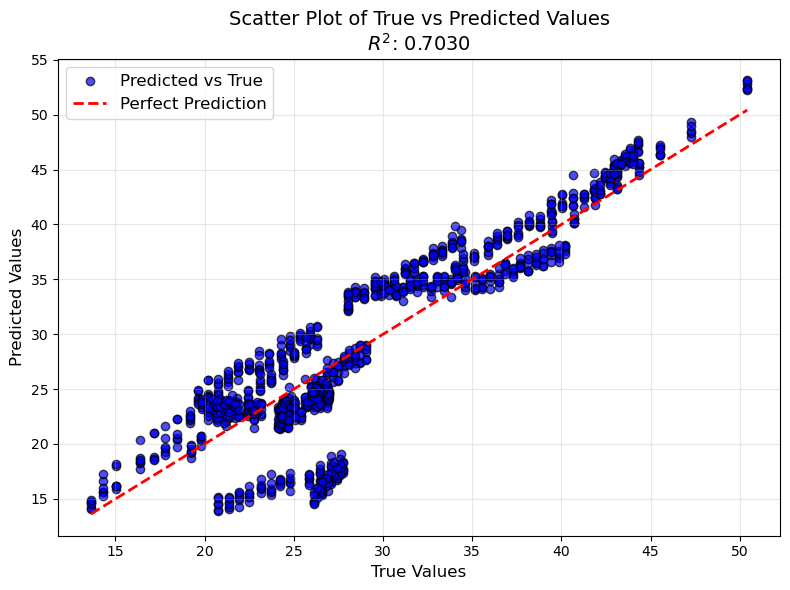

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test, y_test_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Scatter Plot of True vs Predicted Values\n$R^2$: {r2:.4f}", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
